# RetinaMNIST

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during Lecture 8. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits randomly selected from `MNIST` dataset on a canvas of size `(128, 128)`. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [ ]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            str(self.class_nb),
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
           class_nb=class_nb,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        if boxes is None:
            boxes = self.boxes
        #boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [ ]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)

    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit = digits[current_digit_index]
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=classes[current_digit_index],
        ):
            attempts_done += 1
    return new_canvas

11493376/11490434 [==============================] - 0s 0us/step


Let us have a look at example canvas:

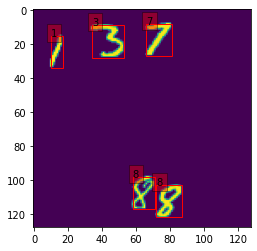

In [ ]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

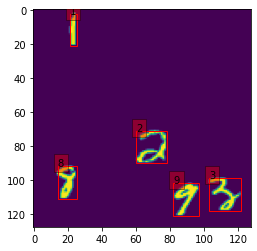

In [ ]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (0.5pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

In [ ]:
import numpy as np

anchor_analysis_samples = [get_random_canvas().boxes for i in range(5000)]
samples_hw = np.array([[box.x_diff, box.y_diff] 
                       for boxes in anchor_analysis_samples 
                       for box in boxes])
print("Example anchors HxW:\n", samples_hw[:10])

Example anchors HxW:
 [[19 14]
 [19  5]
 [19 19]
 [19 14]
 [19 19]
 [19 15]
 [17 19]
 [19 19]
 [19 11]
 [19 19]]


I decided to compute optimal anchors number and their sizes using k-means clustering. 

To find optimal clusters number I run k-means with $k$ values from 2 to 30, and then for each $k$ I check it's Silhouette Coefficient, which I use for further analysis.

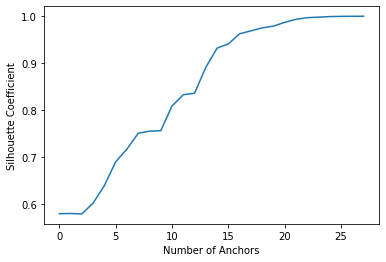

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_coefficients = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(samples_hw)
    score = silhouette_score(samples_hw, kmeans.labels_)
    silhouette_coefficients.append(score)

fig, ax = plt.subplots()
ax.plot(silhouette_coefficients)
ax.set_xlabel("Number of Anchors")
ax.set_ylabel("Silhouette Coefficient")
plt.show()


I decided to plot anchors for $k \in \{5, 13, 17 \}$ based on the Silhouette Coefficients plot. I also plot anchors for $k$ since it seems to be the lowest reasonable value.


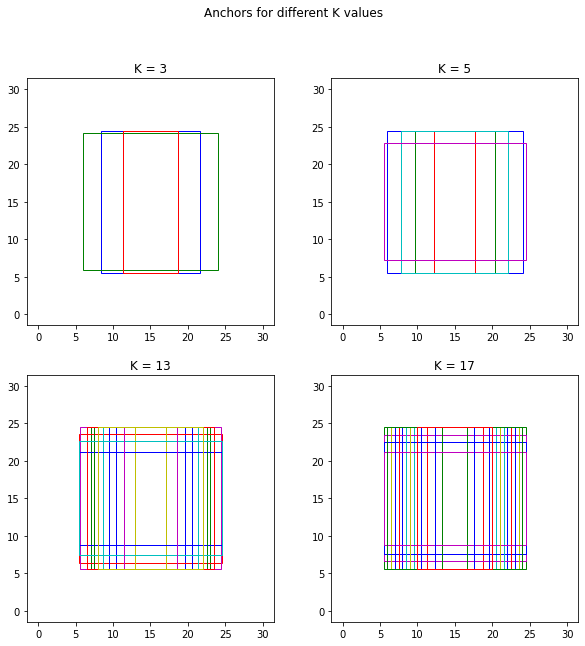

In [ ]:
import matplotlib.patches as patches

def get_anchor_sizes(k, samples):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(samples)

    anchor_sizes = np.array([[0., 0.] for _ in range(k)])
    anch_lab_counts = np.array([0. for _ in range(k)])
    for i in range(len(samples)):
        label = kmeans.labels_[i]
        anchor_sizes[label][0] += samples[i][0]
        anchor_sizes[label][1] += samples[i][1]
        anch_lab_counts[label] += 1

    for i in range(k):
        anchor_sizes[i][0] /= anch_lab_counts[i]
        anchor_sizes[i][1] /= anch_lab_counts[i]
    
    return anchor_sizes

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'b']
fig.suptitle('Anchors for different K values')
fig.set_size_inches(10, 10)

for (k, ax) in zip([3, 5, 13, 17], [ax1, ax2, ax3, ax4]):
    anchors = get_anchor_sizes(k, samples_hw)
    ax.plot([0, 30], [0, 30], linestyle='None')
    ax.set_title('K = ' + str(k))
    for i in range(k):
        rect = patches.Rectangle((15 - anchors[i][1] / 2, 15 - anchors[i][0] / 2), 
                                 anchors[i][1], anchors[i][0], linewidth=1, 
                                 edgecolor=colors[i % len(colors)], 
                                 facecolor='none')
        ax.add_patch(rect)
    ax.set_aspect('equal', adjustable='box')

plt.show()


In my opinion:

*   $k = 17$ seems to be too dense,
*   $k = 13$ looks reasonable, but it's quite high number of anchors,
*   $k = 5$ appears to be much better than $k = 3$.

Therefore I chose 5 as the number of used anchors.





In [ ]:
ANCHOR_SIZES = get_anchor_sizes(5, samples_hw)

### Model building (1pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

Backbone model should accept a `MnistCanvas` instance and output a tensor with shape $(1, \frac{128}{2^k}, \frac{128}{2^k}, filters)$ where $k \in {2, 3, 4}$ and $filters$ should be selected by student. We will later relate to selected $k$ as a stride. You can use a pretrained backbone.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 2^k, \left(n + \frac{1}{2}\right) * 2^k\right)$  for $m, n \in \{0, 1, \dots, \frac{128}{2^k} - 1\}$.

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{classificationHead}$:

$\texttt{classificationHead}$ should accept backbone output as an input and output `classification_output` tensor of shape $(len(\texttt{anchors)}, 10)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j$(ground truth box).

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [ ]:
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms

class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.classification_output = classification_output
        self.box_regression_output = box_regression_output


class DigitDetectionModel(torch.nn.Module):
    def get_backbone(self):
        rn18 = models.resnet18(pretrained=True)
        feature_extr_layers = list(rn18.children())[:-2]
        rn18 = nn.Sequential(*feature_extr_layers)
        for p in rn18.parameters():
            p.requires_grad = False
        
        return rn18

    def get_anchor_boxes(self, k):
        mn_vals = [i for i in range(int(128/2**k))]
        centers = [[(n + 0.5) * 2**k, (m + 0.5) * 2**k] 
                   for n in mn_vals for m in mn_vals]
        anchor_boxes = [MnistBox(round(c[0] - a_size[0] / 2), 
                                 round(c[1] - a_size[1] / 2),
                                 round(c[0] + a_size[0] / 2), 
                                 round(c[1] + a_size[1] / 2)) 
        for c in centers for a_size in ANCHOR_SIZES]

        return anchor_boxes

    # Should use ANCORS_SIZES
    def __init__(
        self,
        k
    ):
        super().__init__()        
        self.first_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=(1, 1))
        
        self.backbone = self.get_backbone()
        
        self.class_subnet = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=len(ANCHOR_SIZES) * 10, 
                      kernel_size=(3, 3), padding=(1, 1)),
        )

        self.box_subnet = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=len(ANCHOR_SIZES) * 4, 
                      kernel_size=(3, 3), padding=(1, 1)),
        )
        
        self.anchors = self.get_anchor_boxes(k)
        self.k = k

    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
        x = nn.functional.interpolate(x, size=2**(12 - self.k)).to(DEVICE)
        x = self.first_layer(x)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        x = normalize(x).to(DEVICE)
        x = self.backbone(x)

        cl = self.class_subnet(x)
        cl = cl.permute([0, 2, 3, 1]).reshape(len(self.anchors), 10)

        bx = self.box_subnet(x)
        bx = bx.permute([0, 2, 3, 1]).reshape(len(self.anchors), 4)

        return DigitDetectionModelOutput(
            anchors=self.anchors,
            classification_output=cl.to(DEVICE),
            box_regression_output=bx.to(DEVICE)
        )


### Significant overlap (1pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `classification_target` - a tensor of shape $(len(anchors), 10)$,
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

and `classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{class_targets}[i, \texttt{gt_best.class_nb}] = 1.$$

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [ ]:
import torchvision
from torchvision import ops

class DigitDetectionModelTarget:

    def __init__(
        self,
        classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.classification_target = classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors

def anchors_to_tensor(anchor_list):
    anchors_dims = [[anchor.x_min, anchor.y_min, anchor.x_max, anchor.y_max] 
                   for anchor in anchor_list]
    anchors_ten = torch.tensor(anchors_dims).to(DEVICE)
    return anchors_ten

class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.5,
        nb_of_classes: int = 10,
    ) -> DigitDetectionModelTarget:
        classification_target = torch.zeros(len(anchors), 
                                            nb_of_classes).to(DEVICE)
        box_regression_target = torch.zeros(len(anchors), 4).to(DEVICE)
        matched_anchors = []
        for i in range(len(anchors)):
            gt_best_iou = 0.
            gt_best = None
            for box in canvas.boxes:
                iou = box.iou_with(anchors[i])
                if iou > iou_threshold and iou > gt_best_iou:
                    gt_best_iou = iou
                    gt_best = box
            
            if gt_best:
                classification_target[i][gt_best.class_nb] = 1
                box_regression_target[i][0] = gt_best.x_min - anchors[i].x_min
                box_regression_target[i][1] = gt_best.y_min - anchors[i].y_min
                box_regression_target[i][2] = gt_best.x_max - anchors[i].x_max
                box_regression_target[i][3] = gt_best.y_max - anchors[i].y_max
                matched_anchors.append(i)

        return DigitDetectionModelTarget(classification_target, 
                                         box_regression_target, 
                                         matched_anchors)

    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        sigmoid_class_output = torch.sigmoid(model_output.classification_output)
        scores, class_nbs = torch.max(sigmoid_class_output, dim=1)
        top_scores, top_idx = torch.topk(scores, 1000)

        boxes = torch.add(anchors_to_tensor(model_output.anchors), 
                          model_output.box_regression_output)
        top_boxes = torch.index_select(boxes, 0, top_idx).to(DEVICE)
        top_classes = torch.index_select(class_nbs, 0, top_idx).to(DEVICE)
        
        nms_ids = ops.nms(top_boxes, top_scores, iou_threshold=0.1)
        predictions = []
        for i in nms_ids:
            if top_scores[i].item() > 0.25:
                predictions.append(MnistBox(top_boxes[i][0].item(), 
                                            top_boxes[i][1].item(), 
                                            top_boxes[i][2].item(), 
                                            top_boxes[i][3].item(), 
                                            top_classes[i].item()))

        return predictions


### Metrics (0.5pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between classes predictions and targets averaged only over matched anchors.

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [ ]:
import torch
import torchvision 


class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
        matched_anchors = model_target.matched_anchors
        if len(matched_anchors) == 0:
            return None
        
        matched_anchors_tens = torch.tensor(matched_anchors).to(DEVICE)

        box_reg_targets = torch.index_select(model_target.box_regression_target,
                                             0, matched_anchors_tens).to(DEVICE)
        box_reg_preds = torch.index_select(model_output.box_regression_output, 
                                           0, matched_anchors_tens).to(DEVICE)                
                
        smooth_loss = torch.nn.SmoothL1Loss(reduction='mean')
        smooth_sum = smooth_loss(box_reg_preds, box_reg_targets)
        focal_sum = ops.sigmoid_focal_loss(model_output.classification_output, 
                                           model_target.classification_target, 
                                           reduction='mean')

        return smooth_sum.add(focal_sum).to(DEVICE)


class DigitAccuracy:

    def compute_metric(
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
        digits = canvas.boxes
        if len(digits) != len(predicted_boxes):
            return 0

        matched_digits = []
        for pred in predicted_boxes:
            match_found = False
            for i in range(len(digits)):
                if digits[i].iou_with(pred) > 0.5 and digits[i].class_nb == pred.class_nb:
                    if match_found or (i in matched_digits):
                        return 0
                    match_found = True
                    matched_digits.append(i)
            if not match_found:
                return 0
        
        return 1


### Train your model (1pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (0.5pt).

_Hint:_ note that all classes defined above accept only a single canvas as their inputs. Can we extend a training loop to use it for a training on batches?

Have fun!

In [ ]:
import torch.optim as optim
import random

def plot_targets(targets, anchors):
    mnist_boxes = []
    boxes = torch.add(anchors_to_tensor(anchors), targets.box_regression_target).to(DEVICE)
    scores, class_nbs = torch.max(targets.classification_target, dim=1)
    class_nbs = class_nbs.to(DEVICE)
    for i in targets.matched_anchors:
        mnist_boxes.append(MnistBox(boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item(), class_nbs[i].item()))

    return mnist_boxes

class DigitDetectionTrainer(object):
    def __init__(self, testset, net, canvas_per_epoch=1000, epochs=20):
        self.testset = testset
        self.net = net
        self.canvas_per_epoch = canvas_per_epoch
        self.epochs = epochs

    def train(self):
        losses = []
        accuracies = []
        epochs = []
        self.net = self.net.to(DEVICE)
        criterion = RetinaLoss()
        target_decoder = TargetDecoder()
        acc = DigitAccuracy()
        optimizer = optim.Adam(self.net.parameters(), lr=0.0001)
        for epoch in range(self.epochs):
            trainset = [get_random_canvas() for _ in range(self.canvas_per_epoch)]
            epoch_loss = 0.0
            c = 0
            for canvas in trainset:
                optimizer.zero_grad()
                output = net(canvas.get_torch_tensor())
                predictions = target_decoder.get_predictions(output)
                targets = target_decoder.get_targets(canvas, output.anchors)
                loss = criterion.compute_loss(output, targets)
                if loss:
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    c += 1

            epoch_loss = epoch_loss / c
            print("Epoch: ", epoch)
            print("Loss: ", epoch_loss)

            correct = 0
            total = 0
            matched_canvas = []
            mismatched_canvas = []
            with torch.no_grad():
                for canvas in self.testset:
                    output = net(canvas.get_torch_tensor())
                    predictions = target_decoder.get_predictions(output)
                    targets = target_decoder.get_targets(canvas, output.anchors)

                    m = acc.compute_metric(predictions, canvas)
                    if m == 1 and len(matched_canvas) < 2:
                        matched_canvas.append((canvas, predictions))
                    elif len(mismatched_canvas) < 2:
                        mismatched_canvas.append((canvas, predictions))
                    total += 1
                    correct += m

            accuracy = 100 * correct / total 
            print("Accuracy on testset: " + str(accuracy) + "%")
            if correct > 0:
                print("Matched predictions examples:")
                for (canvas, predictions) in matched_canvas:
                    canvas.plot(predictions)
            
            print("Mismatched predictions examples:")
            for (canvas, predictions) in mismatched_canvas:
                print("Prediction:")
                canvas.plot(predictions)
                print("Target:")
                canvas.plot()

            print("-" * 45)
            accuracies.append(accuracy)
            losses.append(epoch_loss)
            epochs.append(epoch + 1)
        return losses, accuracies, epochs


**Plotted mismatched predictions repeat themselves after few epochs due to and error in training class (plotted mismatched predictions should be taken at random).**

**Unfortunately I didn't have time to train model again before the deadline.**

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch:  0
Loss:  0.6133964207555567
Accuracy on testset: 1.953125%
Matched predictions examples:


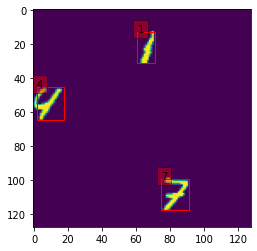

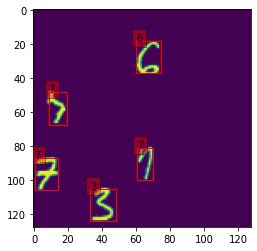

Mismatched predictions examples:
Prediction:


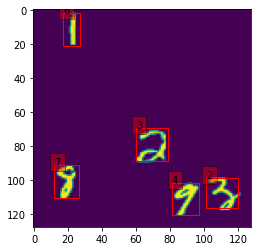

Target:


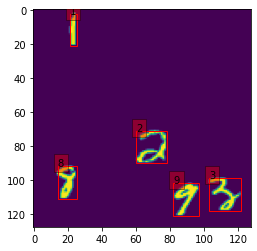

Prediction:


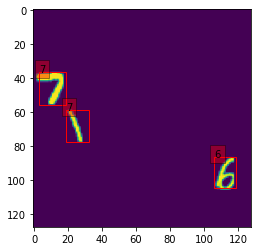

Target:


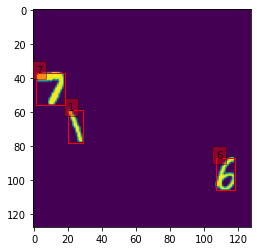

---------------------------------------------
Epoch:  1
Loss:  0.3304623982203858
Accuracy on testset: 18.75%
Matched predictions examples:


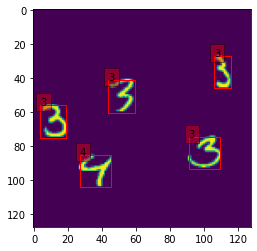

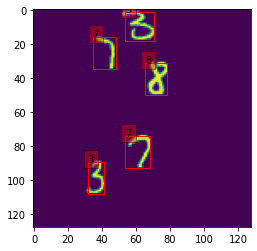

Mismatched predictions examples:
Prediction:


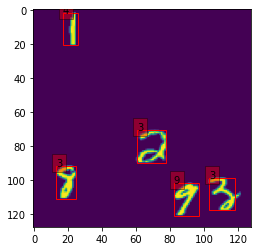

Target:


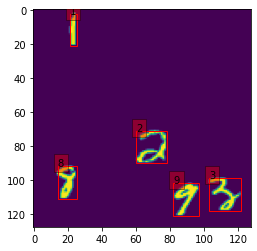

Prediction:


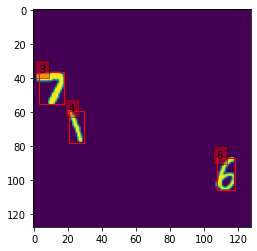

Target:


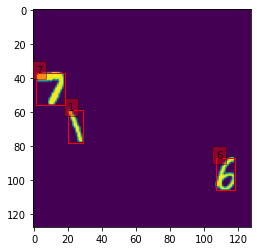

---------------------------------------------
Epoch:  2
Loss:  0.2556770866523896
Accuracy on testset: 42.1875%
Matched predictions examples:


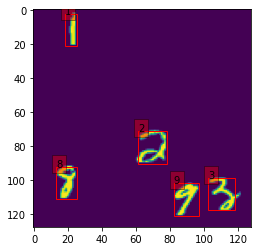

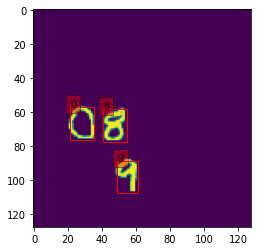

Mismatched predictions examples:
Prediction:


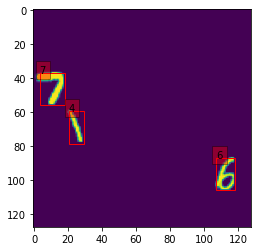

Target:


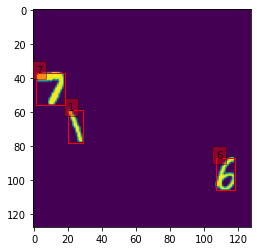

Prediction:


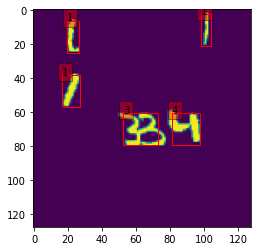

Target:


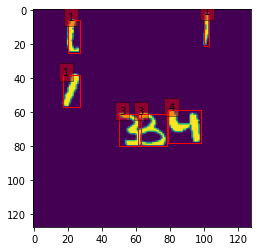

---------------------------------------------
Epoch:  3
Loss:  0.21068821440849986
Accuracy on testset: 57.421875%
Matched predictions examples:


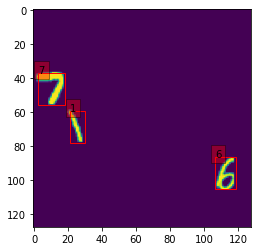

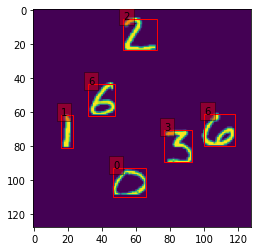

Mismatched predictions examples:
Prediction:


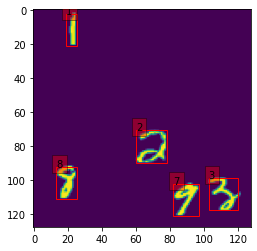

Target:


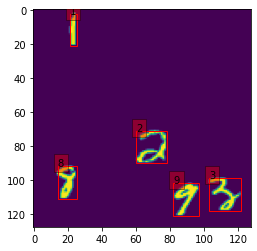

Prediction:


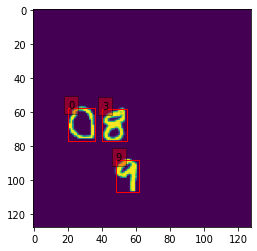

Target:


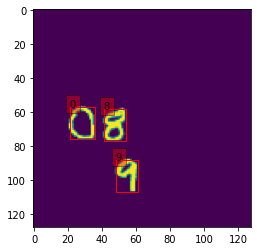

---------------------------------------------
Epoch:  4
Loss:  0.1859033743132438
Accuracy on testset: 48.828125%
Matched predictions examples:


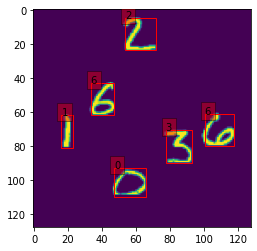

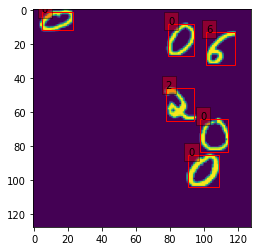

Mismatched predictions examples:
Prediction:


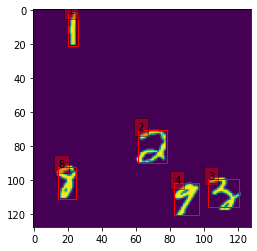

Target:


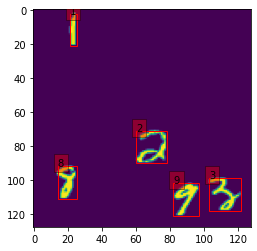

Prediction:


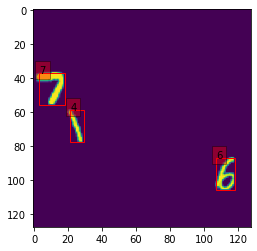

Target:


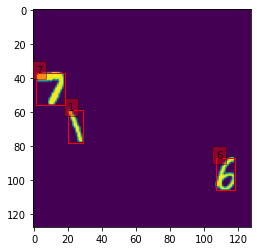

---------------------------------------------
Epoch:  5
Loss:  0.16262928680915917
Accuracy on testset: 55.078125%
Matched predictions examples:


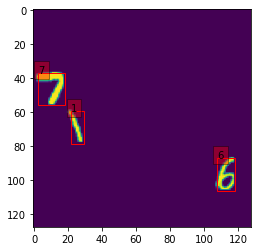

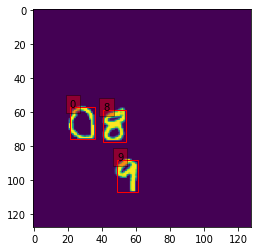

Mismatched predictions examples:
Prediction:


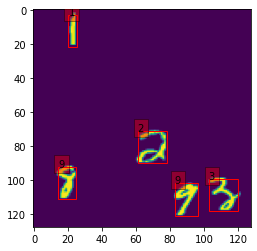

Target:


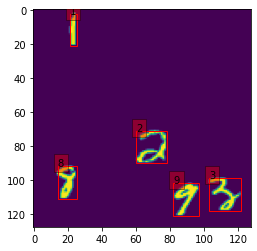

Prediction:


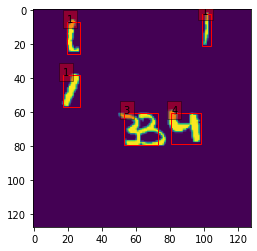

Target:


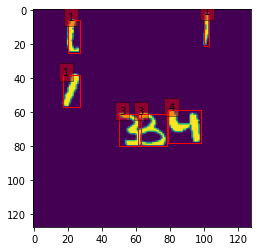

---------------------------------------------
Epoch:  6
Loss:  0.1558741377107799
Accuracy on testset: 62.109375%
Matched predictions examples:


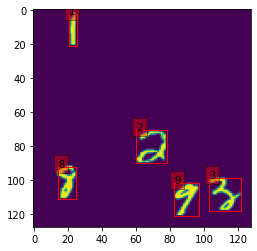

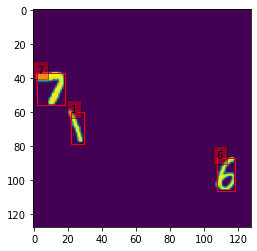

Mismatched predictions examples:
Prediction:


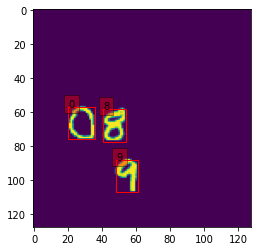

Target:


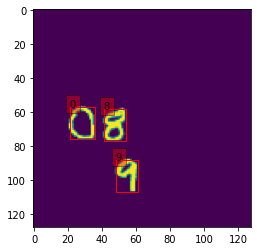

Prediction:


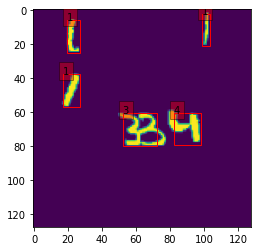

Target:


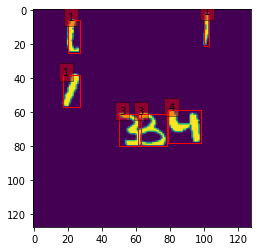

---------------------------------------------
Epoch:  7
Loss:  0.14309966665825674
Accuracy on testset: 55.46875%
Matched predictions examples:


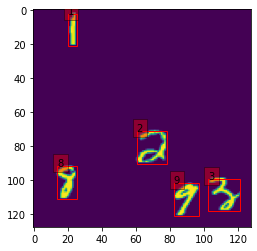

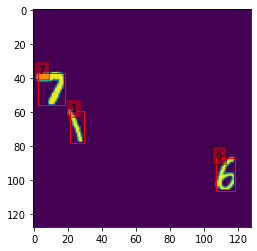

Mismatched predictions examples:
Prediction:


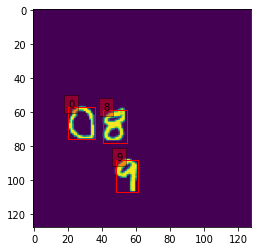

Target:


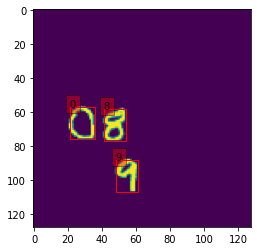

Prediction:


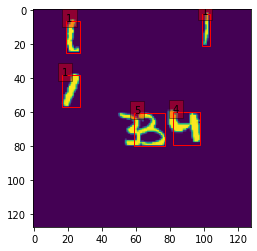

Target:


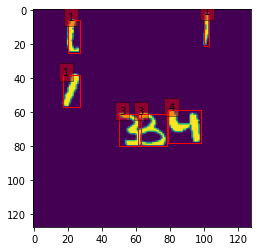

---------------------------------------------
Epoch:  8
Loss:  0.1306358097812959
Accuracy on testset: 60.9375%
Matched predictions examples:


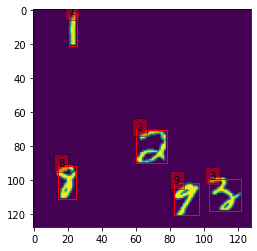

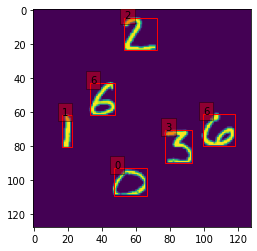

Mismatched predictions examples:
Prediction:


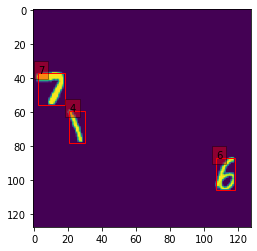

Target:


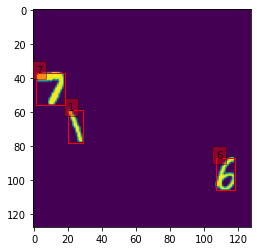

Prediction:


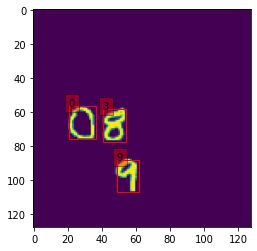

Target:


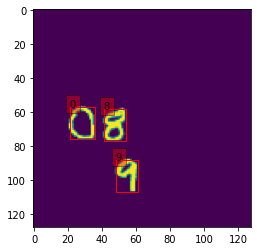

---------------------------------------------
Epoch:  9
Loss:  0.12519723915894115
Accuracy on testset: 61.328125%
Matched predictions examples:


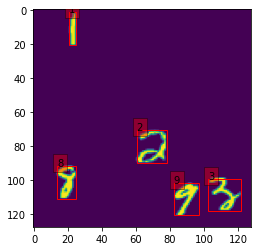

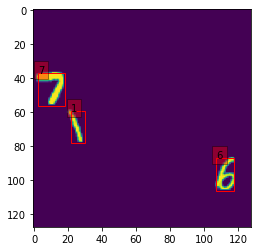

Mismatched predictions examples:
Prediction:


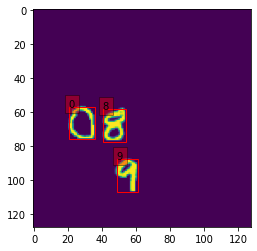

Target:


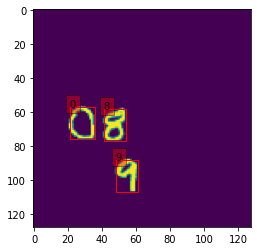

Prediction:


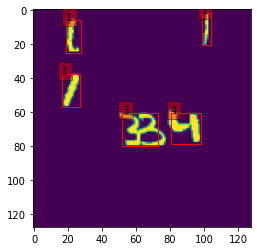

Target:


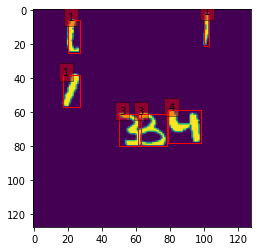

---------------------------------------------
Epoch:  10
Loss:  0.12649061373035822
Accuracy on testset: 62.109375%
Matched predictions examples:


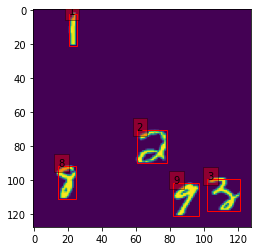

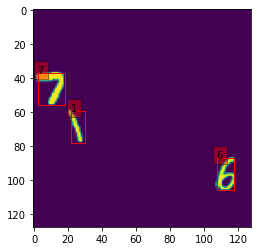

Mismatched predictions examples:
Prediction:


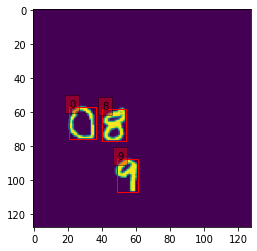

Target:


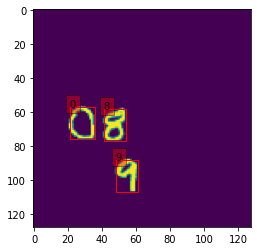

Prediction:


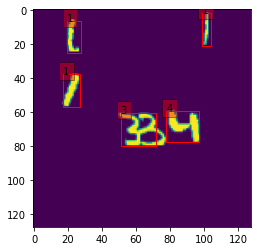

Target:


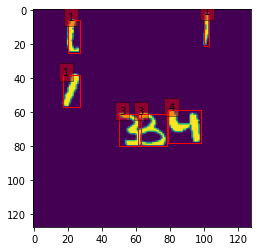

---------------------------------------------
Epoch:  11
Loss:  0.12252424402162433
Accuracy on testset: 66.796875%
Matched predictions examples:


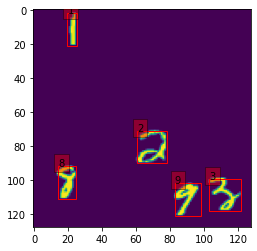

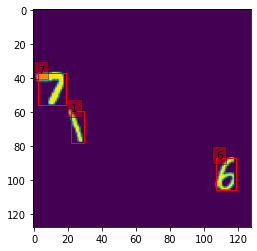

Mismatched predictions examples:
Prediction:


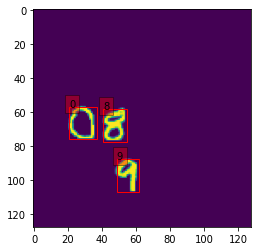

Target:


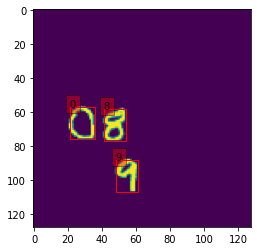

Prediction:


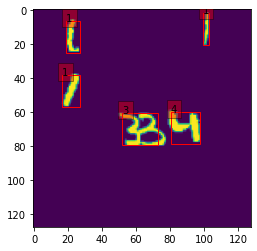

Target:


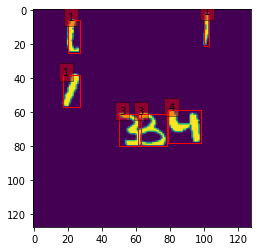

---------------------------------------------
Epoch:  12
Loss:  0.1133595922589302
Accuracy on testset: 61.328125%
Matched predictions examples:


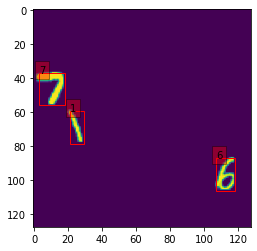

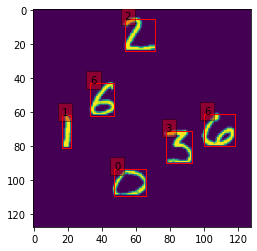

Mismatched predictions examples:
Prediction:


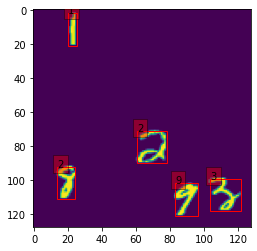

Target:


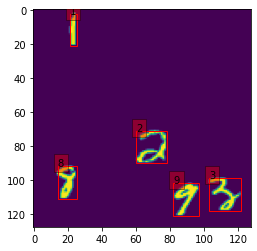

Prediction:


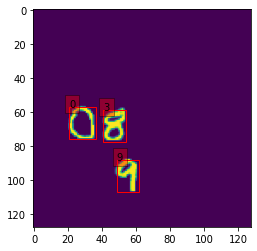

Target:


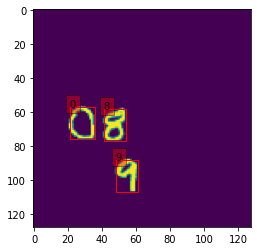

---------------------------------------------
Epoch:  13
Loss:  0.12020077954711658
Accuracy on testset: 59.375%
Matched predictions examples:


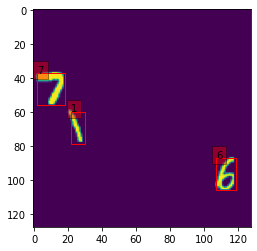

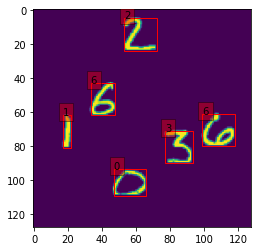

Mismatched predictions examples:
Prediction:


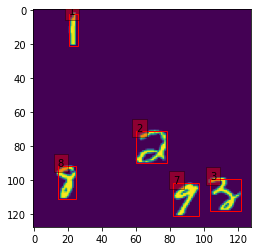

Target:


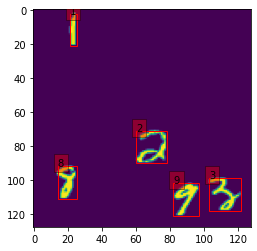

Prediction:


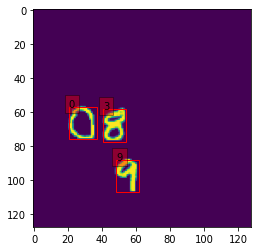

Target:


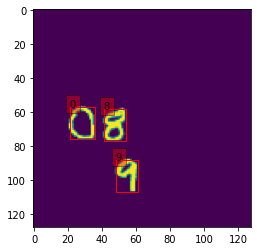

---------------------------------------------
Epoch:  14
Loss:  0.10883716167083808
Accuracy on testset: 64.0625%
Matched predictions examples:


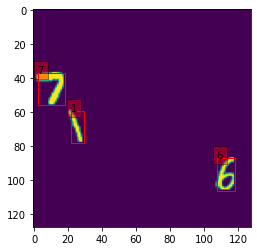

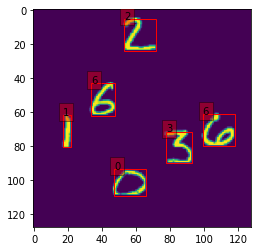

Mismatched predictions examples:
Prediction:


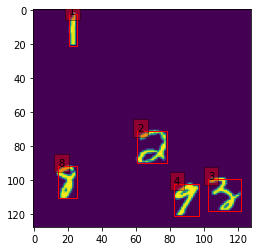

Target:


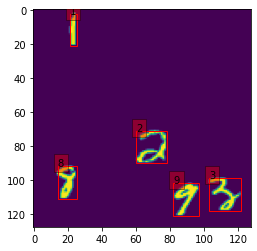

Prediction:


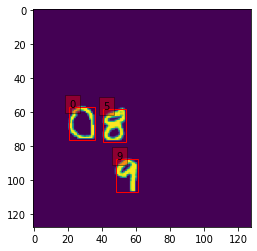

Target:


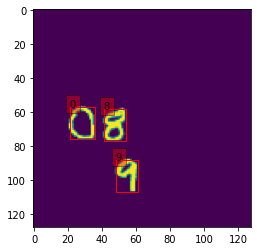

---------------------------------------------
Epoch:  15
Loss:  0.10977805603561656
Accuracy on testset: 62.5%
Matched predictions examples:


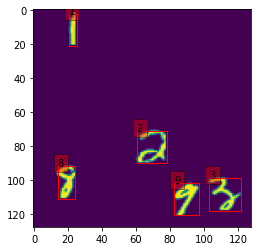

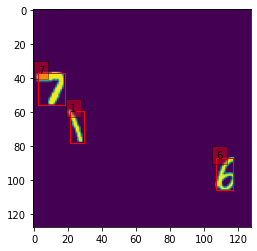

Mismatched predictions examples:
Prediction:


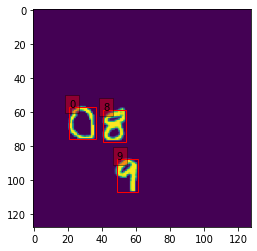

Target:


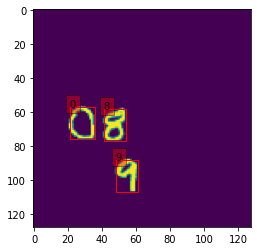

Prediction:


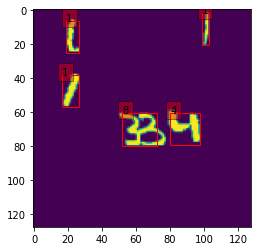

Target:


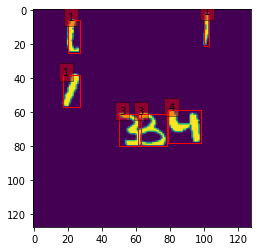

---------------------------------------------
Epoch:  16
Loss:  0.10322814575795616
Accuracy on testset: 63.28125%
Matched predictions examples:


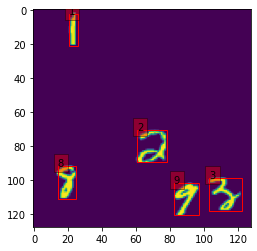

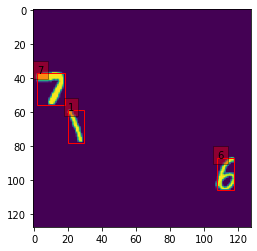

Mismatched predictions examples:
Prediction:


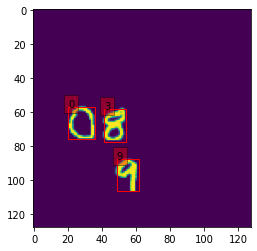

Target:


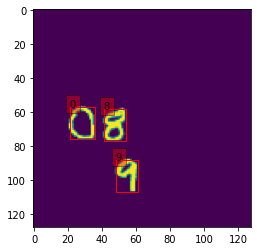

Prediction:


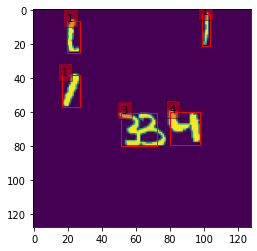

Target:


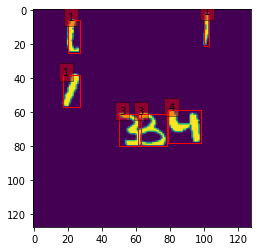

---------------------------------------------
Epoch:  17
Loss:  0.09977565024314182
Accuracy on testset: 68.359375%
Matched predictions examples:


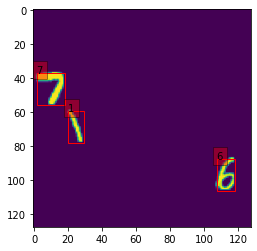

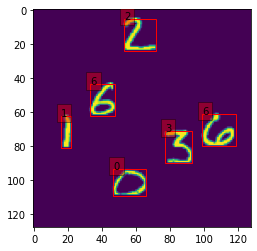

Mismatched predictions examples:
Prediction:


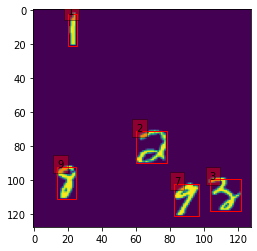

Target:


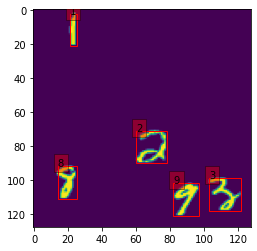

Prediction:


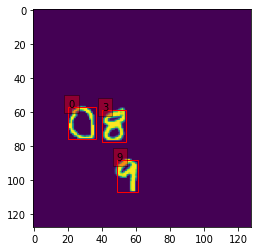

Target:


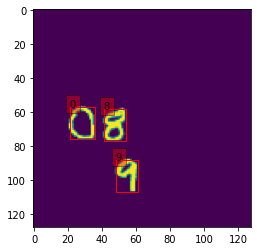

---------------------------------------------
Epoch:  18
Loss:  0.10135964875774724
Accuracy on testset: 62.109375%
Matched predictions examples:


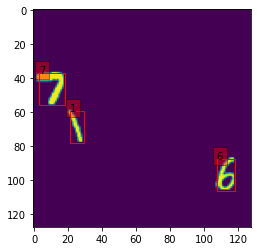

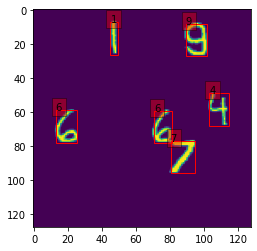

Mismatched predictions examples:
Prediction:


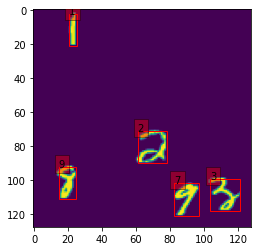

Target:


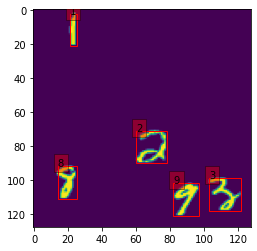

Prediction:


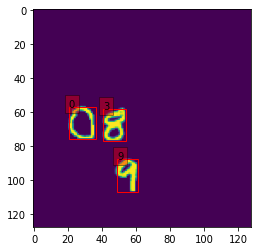

Target:


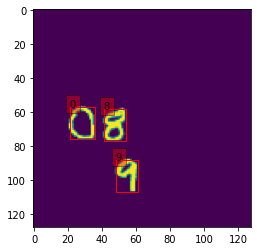

---------------------------------------------
Epoch:  19
Loss:  0.09570323951542377
Accuracy on testset: 71.484375%
Matched predictions examples:


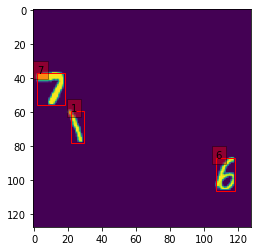

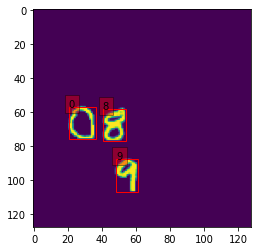

Mismatched predictions examples:
Prediction:


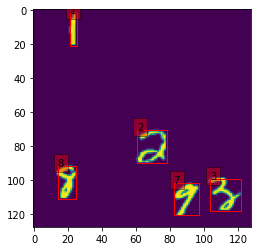

Target:


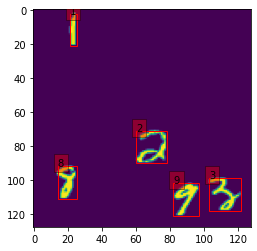

Prediction:


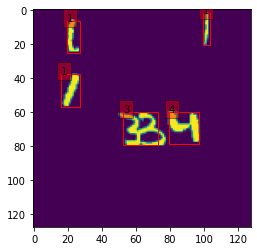

Target:


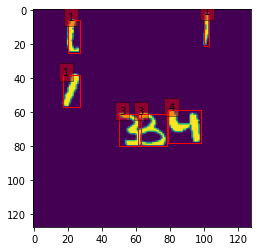

---------------------------------------------


In [13]:
net = DigitDetectionModel(2).to(DEVICE)
trainer = DigitDetectionTrainer(TEST_CANVAS, net, canvas_per_epoch=700)
losses, accuracies, epochs = trainer.train()

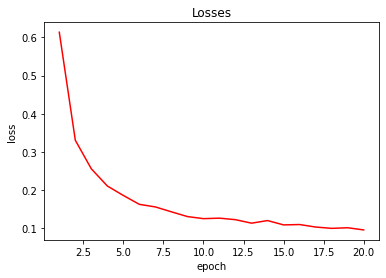

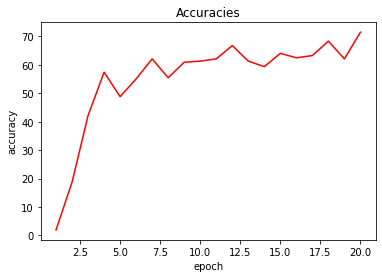

In [14]:
fig1, ax1 = plt.subplots()
ax1.set_title("Losses")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(epochs, losses, color="red")
fig1.savefig("losses.eps", format='eps')

fig2, ax2 = plt.subplots()
ax2.set_title("Accuracies")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.plot(epochs, accuracies, color="red")
fig2.savefig("accuracies.eps", format='eps')